## This notebook is for modeling tip percentage with features processed by the previous notebook named as '2-1, Predicting tip percentage, data processing & feature engineering'. 

We will use three models - Linear Regression, XGBoost and Deep Neural Network. We will look at both the 'mean squared error' and the 'prediction vs. fact' plot to evaluate and compare model performance

### magic shortcuts to different models:

1. [Linear Regression](#1)
2. [XGBoost](#2)
3. [Deep Learning](#3)
4. [Conclusion](#4)

In [14]:
# load library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error # evaluation metrics
from scipy import sparse

In [11]:
# load data
train_x = pickle.load(open('../../data/train_x.p', 'rb' ))
train_y = pickle.load(open('../../data/train_y.p', 'rb' ))
test_x = pickle.load(open('../../data/test_x.p', 'rb' ))
test_y = pickle.load(open('../../data/test_y.p', 'rb' ))

<a id = 1> </a>
## 1, Linear Regression

First, we will try a simple model - linear regression, as a baseline model to compare with.

In [3]:
# modeling
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept = True, normalize = True)
regr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [10]:
# evaluate model on testing data
regr_pred = regr.predict(test_x)
mean_squared_error(regr_pred, test_y)

24.322271551093223

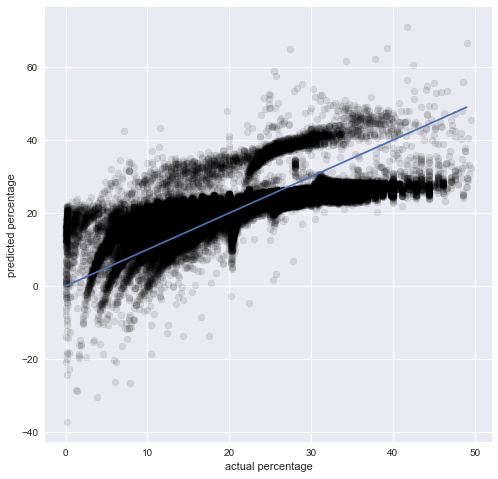

In [16]:
# Plot outputs
# x-axis, actual value; 
# y-axis, predicted value.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.set_xlabel('actual percentage')
ax.set_ylabel('predicted percentage')

plt.scatter(test_y, regr_pred, color='black', alpha = .1)

# diagnoal line indicating perfect prediction
plt.plot(np.arange(0, 50), np.arange(0, 50)) 

plt.show()

<a id = 2> </a>
## 2, XGBoost

Reference: https://xgboost.readthedocs.io/en/latest/

Due to unknown reasons, the jupyter notebook would be frozen when the XGBoost model was initiated to train with a Bayesian optimization package (https://github.com/fmfn/BayesianOptimization). Intead of using jupyter notebook, the model was trained by calling a python program in Termial. 

The model was optimized to have the cross-validated mean squared error of 3.304 with several hyper-parameters been tuned as:
'reg_alpha': 0,
'reg_lambda': 10,
'colsample_bytree': 0.1,
'subsample': 1,
'min_child_weight': 1,
'max_depth': 20,
'alpha': 0,
'gamma': 0

A detailed explanation of these parameters can be found here: https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

In [2]:
# load libaray
import xgboost as xgb

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [1]:
# tuned parameter:
params = {  'n_estimators': 1000,
            'reg_alpha': 0,
            'reg_lambda': 10,
            'colsample_bytree': 0.1,
            'subsample': 1,
            'min_child_weight': 1,
            'max_depth': 20,
            'gamma': 0,
            'learning_rate': .1
         }

In [3]:
# fit into training data to gererate model for prediction
xgb_regr = xgb.XGBRegressor(**params, nthread = 2)
xgb_regr.fit(train_x, train_y)

In [ ]:
# save model for future reference
with open('./xgboost_model.p', 'wb') as handle:
    pickle.dump(xgb_regr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# next time, load model from here:
xgb_regr = pickle.load(open('../../xgboost_model.p', 'rb' ))

In [12]:
# evaluate model on testing data
xgb_pred = xgb_regr.predict(test_x)
np.mean(np.square(xgb_pred - test_y))

7.3725706618518627

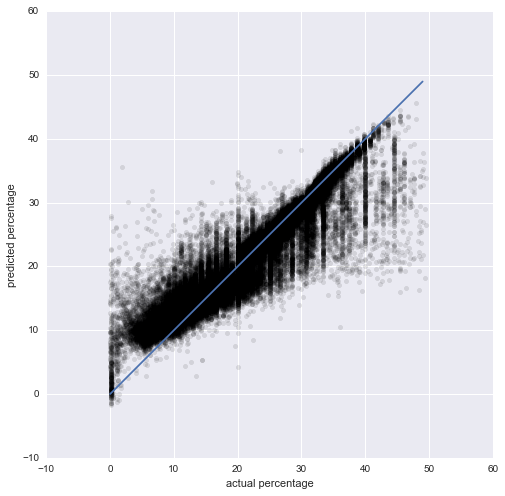

In [15]:
# Plot outputs
# x-axis, actual value; 
# y-axis, predicted value.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.set_xlabel('actual percentage')
ax.set_ylabel('predicted percentage')

plt.scatter(test_y, xgb_pred, color='black', alpha = .1)

# diagnoal line indicating perfect prediction
plt.plot(np.arange(0, 50), np.arange(0, 50)) 

plt.show()

<a id = 3> </a>
## 3, Deep Neural Network

The network architecture was inspired by this article: http://gonzalopla.com/deep-learning-nonlinear-regression/. The original architecture was modified to have more hidden layers and more neurons in each layer. This modification decision was made after several experiments with different setups.

In [43]:
# load library
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import Sequential
from keras import backend
from keras.callbacks import EarlyStopping
backend.backend()
import theano
print(theano.config.device) # trained with GPU to speed up computation

cuda0


In [55]:
model = Sequential()
 
# Input layer 128 neurons. 
model.add(Dense(128, input_dim=64, activation='relu'))
# Dropout of 20% of the neurons and activation layer.
model.add(Dropout(.2))
model.add(Activation("relu"))
# Hidden layer with 64 neurons.
model.add(Dense(128, activation='relu'))
# Hidden layer with 64 neurons.
model.add(Dense(64, activation='relu'))
# Hidden layer with 64 neurons.
model.add(Dense(64, activation='relu'))
# Output Layer.
model.add(Dense(1, activation='relu'))
    
    
# Model is derived and compiled using mean square error as loss function
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mean_squared_error"])
 
# Training model with train data. Fixed random seed:
np.random.seed(3)

# Early stopping
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = .001, 
                              patience = 10, verbose = 1, mode = 'auto')
# Training
model.fit(train_x.todense(), train_y, epochs = 1000, batch_size = 4069, 
          validation_split = .2, verbose = 1, callbacks = [early_stopping])

Train on 376352 samples, validate on 94088 samples
Epoch 1/1000
376352/376352 [==============================] - 2s - loss: 104.4011 - mean_squared_error: 104.4011 - val_loss: 32.8661 - val_mean_squared_error: 32.8661
Epoch 2/1000
376352/376352 [==============================] - 1s - loss: 27.2138 - mean_squared_error: 27.2138 - val_loss: 21.8419 - val_mean_squared_error: 21.8419
Epoch 3/1000
376352/376352 [==============================] - 1s - loss: 17.4479 - mean_squared_error: 17.4479 - val_loss: 24.7519 - val_mean_squared_error: 24.7519
Epoch 4/1000
376352/376352 [==============================] - 1s - loss: 13.2230 - mean_squared_error: 13.2230 - val_loss: 19.1820 - val_mean_squared_error: 19.1820
Epoch 5/1000
376352/376352 [==============================] - 1s - loss: 11.3641 - mean_squared_error: 11.3641 - val_loss: 18.6287 - val_mean_squared_error: 18.6287
Epoch 6/1000
376352/376352 [==============================] - 1s - loss: 10.2673 - mean_squared_error: 10.2673 - val_loss:

In [64]:
# save model for future reference
model_json = model.to_json()
import json
with open('./deep_learning_model.json', 'w') as outfile:
    json.dump(model_json, outfile)

In [19]:
# next time, load model from here
import json
from keras.models import model_from_json
with open('./deep_learning_model.json') as model_file:
    model_json = json.loads(model_file.read())
model1 = model_from_json(model_json)

In [77]:
# evaluate model on testing data
dl_pred = model.predict(test_x.todense())
mean_squared_error(dl_pred, test_y)

3.9055187968490483

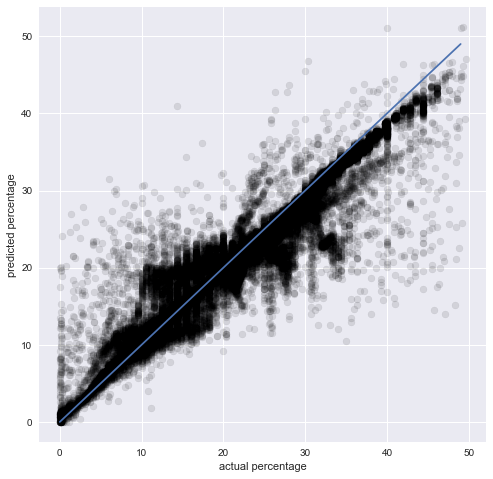

In [78]:
# Plot outputs
# x-axis, actual value; 
# y-axis, predicted value.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.set_xlabel('actual percentage')
ax.set_ylabel('predicted percentage')

plt.scatter(test_y, dl_pred, color='black', alpha = .1)

# diagnoal line indicating perfect prediction
plt.plot(np.arange(0, 50), np.arange(0, 50)) 

plt.show()

<a id = 4> </a>
## 4, Conclusion

The analysis above suggests the deep learning model outperforms the other two models. It is clear that the deep learning model has a lowered mean squared error in the testing dataset: 3.906 as opposed to 7.373 of the XGBoost model and 24.322 of the Linear Regression model. The plot of predicted against actual values also supports this.

It is noteworthy to point out that the model performance can be further improved by various ways that have been ignored by this exercise due to time constraint. For example, applying Box-Cox transformation on continuously-valued features is often a widely accepted technique to improve prediction results. Moreover, there are transactions with fare around $1, which are dubious ones because the low amount of money. It might be helpful to exclude these transactions from the analysis.

Finally, the analysis didn't include cases with zero tip. However, given the large amount of zero tip transactions (over half of the total transactions. Some New Yorkers are so mean!!!), we might want to consider to design a classification model to predict the probability that if tips will be paid. If the
classification model gives a positive prediction, we will use a second model for regression prediction.